In [1]:
import lkTables
import numpy as np
import matplotlib.pyplot as plt
lookupT=lkTables.scattTables()


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): dim_0(289), dim_1(8)
    variables(dimensions): float32 kextR(dim_0, dim_1), float32 salbR(dim_0, dim_1), float32 asymR(dim_0, dim_1), float32 kextS(dim_0, dim_1), float32 salbS(dim_0, dim_1), float32 asymS(dim_0, dim_1), float32 kextG(dim_0, dim_1), float32 salbG(dim_0, dim_1), float32 asymG(dim_0, dim_1)
    groups: 


In [2]:
dmr=(lookupT.dmr)
zku=(lookupT.zKuR)
print(zku.shape)
dzku2dm=(zku[1:]-zku[:-1])/np.log(dmr[1:]/dmr[:-1])

(289,)


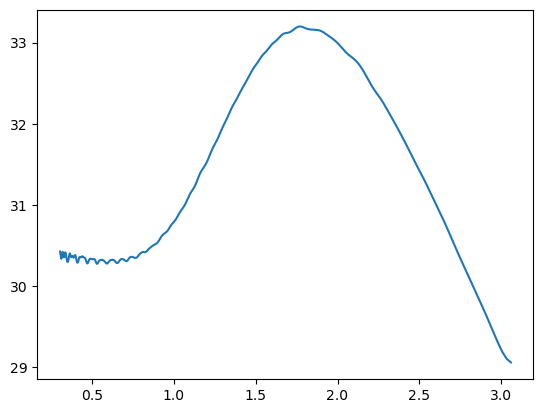

In [5]:
from scipy.ndimage import gaussian_filter1d
for i in range(3):
    dzku2dm=gaussian_filter1d(dzku2dm,1)
plt.plot(dmr[1:],dzku2dm)


In [3]:
#encoding={"zMeas":{"zlib":True,"complevel":compLev},"zFactFinal":{"zlib":True,"complevel":compLev},"bbFlag":{"zlib":True,"complevel":compLev},"bbBottom":{"zlib":True,"complevel":compLev},"bbTop":{"zlib":True,"complevel":compLev},"pType":{"zlib":True,"complevel":compLev},"paramDSD":{"zlib":True,"complevel":compLev},"bzd":{"zlib":True,"complevel":compLev}}
#ds.to_netcdf("DPR_RAIN.h5",encoding=encoding)
from netCDF4 import Dataset
with Dataset("DPR_RAIN_3.h5") as f:
    zMeas=f["zMeas"][:]
    zFactFinal=f["zFactFinal"][:]
    pType=f["pType"][:]
    bbFlag=f["bbFlag"][:]
    paramDSD=f["paramDSD"][:]
print(zMeas.shape)

(157182, 21, 2)


In [4]:

NwCoeff=[-7.07747934,4.63232708]
def invNw(Dm):
    return NwCoeff[1]+NwCoeff[0]*np.log10(Dm)

dm=np.linspace(0.1,3,30)
print(invNw(dm))

[11.70980642  9.57927284  8.3329906   7.44873927  6.76286066  6.20245702
  5.7286425   5.31820569  4.95617477  4.63232708  4.33937121  4.07192345
  3.82589536  3.59810893  3.38604483  3.18767212  3.0013296   2.8256412
  2.65945423  2.5017935   2.35182668  2.20883763  2.07220579  1.94138987
  1.81591489  1.69536178  1.57935895  1.46757535  1.3597148   1.25551126]


In [5]:
a_strat=np.nonzero(pType==1)
print(len(a_strat[0]))
print(lookupT.rainRate)

78744
[3.85136623e-03 4.01948066e-03 4.20500943e-03 4.39207535e-03
 4.58075479e-03 4.77063330e-03 4.96257190e-03 5.15546883e-03
 5.35078114e-03 5.55853173e-03 5.80654759e-03 6.05555577e-03
 6.30808063e-03 6.57377066e-03 6.88114762e-03 7.17499992e-03
 7.43541680e-03 7.71694910e-03 8.03474616e-03 8.38064495e-03
 8.75698961e-03 9.13689937e-03 9.51899588e-03 9.90576483e-03
 1.02937920e-02 1.07422471e-02 1.11931507e-02 1.16497716e-02
 1.21359630e-02 1.26580046e-02 1.31845074e-02 1.37142856e-02
 1.43095236e-02 1.49077298e-02 1.55115938e-02 1.61625911e-02
 1.68354847e-02 1.75178666e-02 1.82324946e-02 1.89881604e-02
 1.97503809e-02 2.05532294e-02 2.14576218e-02 2.23689303e-02
 2.32851859e-02 2.42111105e-02 2.52378024e-02 2.63124667e-02
 2.73964778e-02 2.85406597e-02 2.97116674e-02 3.08922231e-02
 3.22025344e-02 3.35451700e-02 3.48946005e-02 3.63351591e-02
 3.78749259e-02 3.94817665e-02 4.10994105e-02 4.27991077e-02
 4.45614457e-02 4.63887192e-02 4.82942089e-02 5.02839983e-02
 5.23869582e-02 5.

In [6]:

iprof=1000
dmClim=[0.94517076, 0.94036734, 0.93911433, 0.9437732, 0.94586045, 0.9576053, 0.97647756, 0.99625194, 1.0185338, 1.049459, 1.0830851, 1.1147919, 1.1506875, 1.1957927, 1.2320056, 1.2743623, 1.3178225, 1.3699284, 1.418859, 1.4592052, 1.5175681, 1.5664177, 1.6260926, 1.6741775, 1.7518688, 1.800313, 1.8677862, 1.9518514, 2.0332143, 2.1344316, 2.214306, 2.299392, 2.4393437, 2.465485, 2.6277537, 2.6586208]
# initialize Dm with climatology
dmClim=np.array(dmClim)

nMemb=20
from bisectm import bisectm
alpha_nom=10**(-3.199)
beta_nom=0.71
def hb(zKum,alpha,beta,dr,srt_piaKu):
    q=0.2*np.log(10)
    zeta=q*beta*alpha*10**(0.1*zKum*beta)*dr
    zetamax=1.-10**(-srt_piaKu/10.*beta)
    if zeta.cumsum()[-1]>zetamax:
        eps=0.9999*zetamax/zeta.cumsum()[-1]
    else:
        eps=1.0
    corrc=eps*zeta.cumsum()
    zc=zKum-10/beta*np.log10(1-corrc)
    return zc,eps,-10/beta*np.log10(1-corrc[-1])

alphaL=[]
piaEns=[]
piaBinL=[]
piaAdjL=[]
piaAdjBinL=[]
nwdmL=[]
zKuFinalL=[]
pRateL=[]
#for imemb in range(nMemb):
zKuL=[]
zKamL=[]
zKaL=[]
dNwL=[]
dmL=[]
nMemb=10
import tqdm
piaKuL=[]
piaKaL=[]
iprofL=[]
for iprof in tqdm.tqdm(range(len(a_strat[0][:]))):
    for imemb in range(nMemb):
        iprofL.append(iprof)
        sigma=0.5
        Nw_mean=3.9
        mu=0.5
        dr=0.125
        pia=0
        zKum=zMeas[a_strat[0][iprof],1:21,0]
        srt_piaKu=min(30,55-zKum[-1])
        zc,eps,pia=hb(zKum,alpha_nom,beta_nom,dr,srt_piaKu)
        piaEns.append(pia)
        piaBin=0
        dbinsL=[]
        alpha_dnw=[]
        dNwBin=[]
        alpha=0.75+np.random.randn()*0.25
        dnp=np.random.randn()
        sigma=0.75
        for k in range(20):
            ibin=bisectm(lookupT.zKuR[:289].data,289,zc[k])
            piaBin+=lookupT.attKuR[ibin]*dr*2
            dmBin=lookupT.dmr[ibin]
            Nw_inv=invNw(dmBin)
            dnp=0.25*dnp+0.75*np.random.randn()
            dNw_inv=alpha*(Nw_inv-Nw_mean)+dnp*sigma
            alpha_dnw.append(alpha_nom*10**(dNw_inv*(1-beta_nom)))
            dNwBin.append(dNw_inv)
        
        alpha_dnw=np.array(alpha_dnw)
        zc_adj,eps_adj,pia_adj=hb(zKum,alpha_dnw,beta_nom,dr,srt_piaKu)
        pia_adj_bin=0
        piaKa=0
        zKa=[]
        dm1L=[]
        pRate1=[]
        for k in range(20):
            if(zc_adj[k]>0):
                ibin=bisectm(lookupT.zKuR[:289].data,289,zc_adj[k]-10*dNwBin[k])
                pia_adj_bin+=lookupT.attKuR[ibin]*10**dNwBin[k]*dr*2
                piaKa+=lookupT.attKaR[ibin]*10**dNwBin[k]*dr
                zKa1=lookupT.zKaR[ibin]+10*dNwBin[k]-piaKa
                piaKa+=lookupT.attKaR[ibin]*10**dNwBin[k]*dr
                dm1=lookupT.dmr[ibin]
                pRate1.append(lookupT.rainRate[ibin]*10**dNwBin[k])
            else:
                dm1=0
                zKa1=0
                pRate1.append(0)
            dm1L.append(dm1)
            zKa.append(zKa1)
        pRateL.append(pRate1)
        zKaL.append(zKa)
        zKuL.append(zKum)
        zKuFinalL.append(zc_adj)
        zKamL.append(zMeas[a_strat[0][iprof],1:21,1])
        dNwL.append(dNwBin)
        dmL.append(dm1L)
        piaAdjL.append(pia_adj)
        piaAdjBinL.append(pia_adj_bin)
        piaKaL.append(piaKa)
        piaKuL.append(pia_adj_bin)
        piaBinL.append(piaBin)



 10%|█         | 8017/78744 [00:57<08:15, 142.66it/s]

In [129]:
import xarray as xr
zKuX=xr.DataArray(np.array(zKuL),dims=["iprof","nbins"])
zKamX=xr.DataArray(np.array(zKamL),dims=["iprof","nbins"])
zKaX=xr.DataArray(np.array(zKaL),dims=["iprof","nbins"])
dNwX=xr.DataArray(np.array(dNwL),dims=["iprof","nbins"])
dmX=xr.DataArray(np.array(dmL),dims=["iprof","nbins"])
piaKuX=xr.DataArray(np.array(piaKuL),dims=["iprof"])
piaKaX=xr.DataArray(np.array(piaKaL),dims=["iprof"])
zKuFinalX=xr.DataArray(np.array(zKuFinalL),dims=["iprof","nbins"])
pRateX=xr.DataArray(np.array(pRateL),dims=["iprof","nbins"])
ds=xr.Dataset({"zKuMeas":zKuX,"zKaMeas":zKamX,"zKaSim":zKaX,"dNw":dNwX,"dm":dmX,"piaKu":piaKuX,"piaKa":piaKaX,"zKuFinal":zKuFinalX,"pRate":pRateX})

compLev=5
encoding={"zKuMeas":{"zlib":True,"complevel":compLev},"zKaMeas":{"zlib":True,"complevel":compLev},"zKaSim":{"zlib":True,"complevel":compLev},"dNw":{"zlib":True,"complevel":compLev},"dm":{"zlib":True,"complevel":compLev},"piaKu":{"zlib":True,"complevel":compLev},"piaKa":{"zlib":True,"complevel":compLev},"zKuFinal":{"zlib":True,"complevel":compLev},"pRate":{"zlib":True,"complevel":compLev}
ds.to_netcdf("stratiformTrainingDataset.h5",encoding=encoding)
                                       

In [131]:
print(zKuX.shape)

(787440, 20)


200
[[1.         0.67327738]
 [0.67327738 1.        ]]
[[1.         0.98641428]
 [0.98641428 1.        ]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  3  3  3  3  3  3]
 [ 4  4  4  4  4  4  4  4  4  4]
 [ 5  5  5  5  5  5  5  5  5

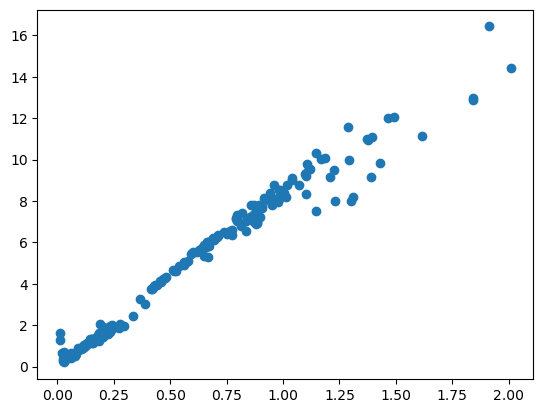

In [125]:
print(len(zKuL))
dNwL=np.array(dNwL)
print(np.corrcoef(dNwL[:,0],dNwL[:,2]))
print(np.corrcoef(piaKuL,piaKaL))
plt.scatter(piaKuL,piaKaL)
print(iprofL)
print(np.array(iprofL).reshape(-1,10))

0.35859152395711347 0.3903951586135758
128011 76407


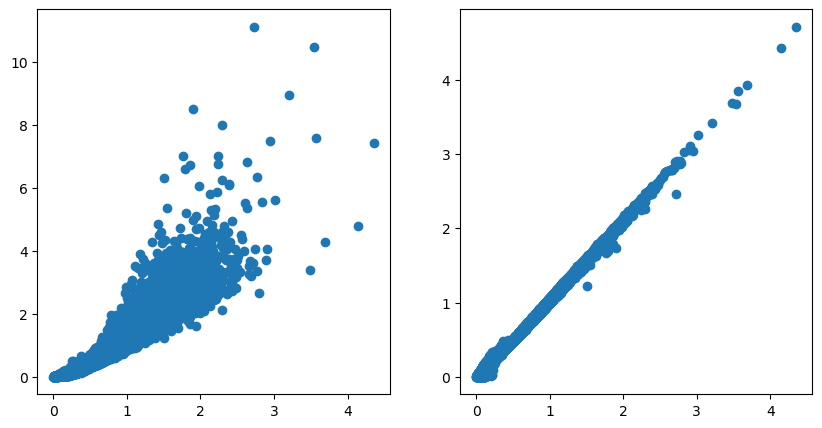

In [77]:
print(np.mean(piaAdj),np.mean(piaBinL))
print(len(piaAdj),len(piaBinL))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(piaAdjL,piaBinL)
plt.subplot(1,2,2)
plt.scatter(piaAdjL,piaAdjBinL)

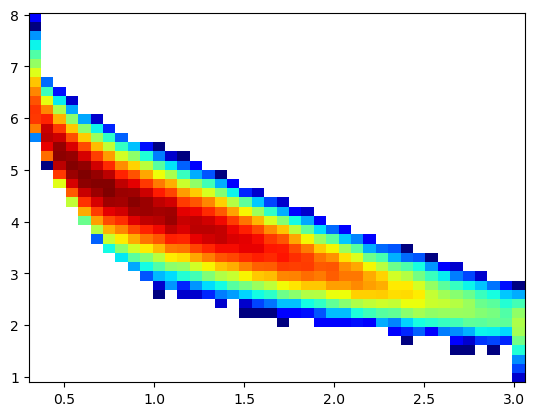

In [76]:
nwdmL=np.array(nwdmL)
h1=plt.hist2d(nwdmL[:,1],3.9+nwdmL[:,0],cmap='jet',norm=plt.cm.colors.LogNorm(),bins=40)

14509439.666234937 194420.3020384898


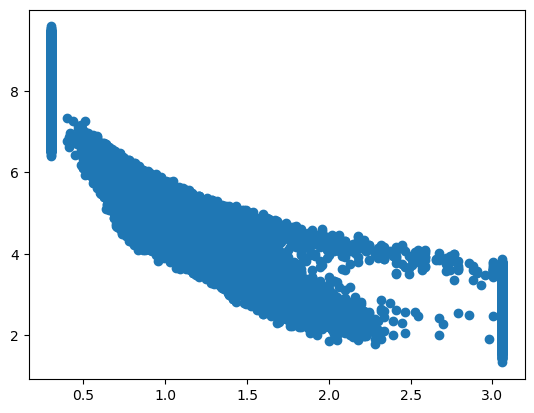

In [39]:
print(np.max(piaEns),np.std(piaEns))
#plt.plot(piaEns)
#plt.scatter(alphaL,piaEns)
#print(np.corrcoef(alphaL,piaEns))
#print(Nw_next,Nw_current)
nwdmL=np.array(nwdmL)
plt.scatter(nwdmL[:,1],nwdmL[:,0])

In [ ]:

#h1=plt.hist(zMeas[a_strat[0][:],1,0],bins=np.linspace(10,45,50))
dm_bins=np.linspace(0,3,50)
zm_bins=np.linspace(10,45,50)
from matplotlib.colors import LogNorm
h1=plt.hist2d(paramDSD[a_strat[0][:],0,1],zMeas[a_strat[0][:],1,0],bins=[dm_bins,zm_bins],cmap="jet",norm=LogNorm())
dm_clim=[]
for i in range(10,46):
    az=np.nonzero((zMeas[a_strat[0][:],1,0]-i)*(zMeas[a_strat[0][:],1,0]-(i+1))<0)
    dm1=(paramDSD[a_strat[0][az],0,1])
    b=np.nonzero(dm1>0)
    dm_clim.append(np.mean(dm1[b]))
    #break
#print(zMeas[a_strat[0][:],1,0][az])
#print(paramDSD[a_strat[0][az],0,1])
plt.plot(dm_clim,np.arange(10,46)+0.5)
#

In [55]:
#print(dm1)
#print(dm1[b])
print(dm_clim)

[0.94517076, 0.94036734, 0.93911433, 0.9437732, 0.94586045, 0.9576053, 0.97647756, 0.99625194, 1.0185338, 1.049459, 1.0830851, 1.1147919, 1.1506875, 1.1957927, 1.2320056, 1.2743623, 1.3178225, 1.3699284, 1.418859, 1.4592052, 1.5175681, 1.5664177, 1.6260926, 1.6741775, 1.7518688, 1.800313, 1.8677862, 1.9518514, 2.0332143, 2.1344316, 2.214306, 2.299392, 2.4393437, 2.465485, 2.6277537, 2.6586208]


In [13]:
import numpy as np
astrat=np.where(pType==3)
print(len(astrat[0])/len(pType))
# 10*dNw/dr+10*dDm/dr* dZ/dDm= dZm/dr + 10**(dNw)*kext(Dm)
nwdml=open("NwDm_dBZ30.txt").readlines()
NwDm=[]
for l in nwdml:
    NwDm.append([float(i) for i in l.split(',')[:-1]])
print(NwDm)
NwDm=np.array(NwDm)
NwDm[:,0]=NwDm[:,0]*0.1

0.23161504416028225
[[7.00743, 5.75466], [8.34198, 5.19067], [10.4228, 4.5113], [12.4312, 3.93543], [14.0699, 3.55517], [15.9338, 3.19777], [17.8724, 2.82883], [20.1117, 2.5057], [22.5748, 2.14796], [24.739, 1.81338], [27.4285, 1.52447], [30.0446, 1.29308]]


Conversion from $mm^{-1} m^{-3}$ to $cm^{-4}$

1e5 $cm^{-4}$ = 1 $mm^{-1} m^{-3}$ to $cm^{-4}$

0.08 $cm^{-4}$ = 0.08*1e6 $mm^{-1} m^{-3}$

log10Nw_ref=3.9

In [ ]:
for k in range(1,19):
        #print(zMeas[a_strat[0][iprof],k],zFactFinal[a_strat[0][iprof],k])
    #get Nw
        zm_current=zMeas[a_strat[0][iprof],k,0]
        zm_next=zMeas[a_strat[0][iprof],k+1,0]
        Nw_current=Nw_next
        Nw_next=Nw_current+sigma*np.random.randn()
        dnw_current=Nw_next-Nw_mean
        dnw_next=Nw_next-Nw_mean
        if zFact_Current>10:
            ifind=bisectm(lookupT.zKuR[:289].data-10*dnw_current,289,zFact_Current-10*dnw_current)
            att_current=lookupT.attKuR[ifind]*10**dnw_current
        else:
            att_current=0
        zFact_Next=zFact_Current+zm_current-zm_next+att_current*dr*2
        if zFact_Next>10:
            ifind_next=bisectm(lookupT.zKuR[:289].data-10*dnw_next,289,zFact_Next-10*dnw_next)
            att_next=lookupT.attKuR[ifind_next]*10**dnw_next
            dm_next=lookupT.dmr[ifind_next]
        else:
            att_next=0
            dm_next=0.5
        Nw_next+=mu*(alpha*invNw(dm_next)-Nw_next)
        dn_next=Nw_next-Nw_mean
        zFact_Next=zFact_Current+zm_current-zm_next+(att_current+att_next)*dr
        ifind_next=bisectm(lookupT.zKuR[:289].data-10*dnw_next,289,zFact_Next-10*dnw_next)
        dm_next=lookupT.dmr[ifind_next]
        Nw_next=Nw_next+mu*(alpha*invNw(dm_next)-Nw_next)
        pia+=(att_current+att_next)*dr
        ibreak=0
        if pia>20:
            print(Nw_next,dm_next,zm_current,zm_next,zFact_Current,zFact_Next,att_current,att_next,pia)
            ibreak=1
            break
        nwdmL.append([Nw_next,dm_next])
    if ibreak==1:
        break


In [42]:
attKuCoeff=np.polyfit(lookupT.zKuR[50:289],np.log10(lookupT.attKuR[50:289]),1)
print(attKuCoeff)

[ 0.07116278 -3.19939512]


In [24]:
fact= 0.1**(-1)*100**(-3)
print(fact/1e-5)
print(np.log10(0.08*1e5))

0.9999999999999998
3.9030899869919438


[-7.07747934  4.63232708]


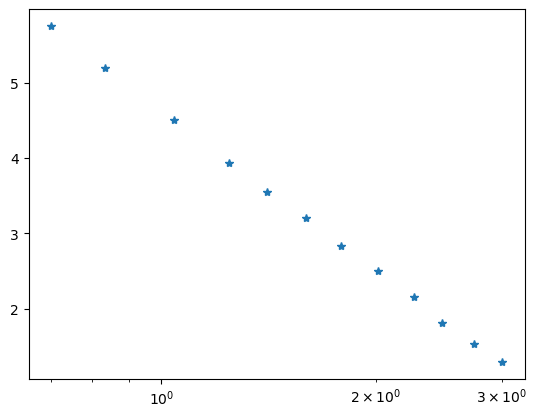

In [17]:
plt.semilogx(NwDm[:,0],NwDm[:,1],'*')
NwCoeffs=np.polyfit(np.log10(NwDm[:,0]),NwDm[:,1],1)
print(NwCoeffs)

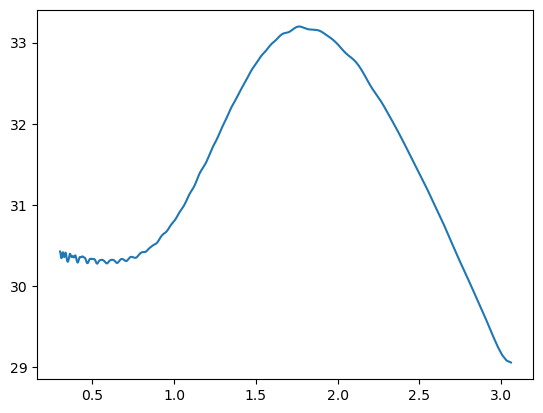

In [6]:

dmrm=(dmr[1:]+dmr[:-1])/2
dzku2dm_Table=np.interp(dmr,dmrm,dzku2dm)
plt.plot(dmr,dzku2dm_Table)
import pickle
pickle.dump({"dzku2dm":dzku2dm_Table,"dmr":dmr},open("dzku2dm.pkl","wb"))